https://github.com/nicknochnack/DeepAudioClassification/blob/main/AudioClassification.ipynb

In [18]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 

#for loading and visualizing audio files
import librosa
import librosa.display

#to play audio
import IPython.display as ipd

from scipy.io import wavfile
import numpy as np
from scipy import signal
import scipy.signal as sps
from scipy.signal import butter, lfilter

In [108]:
noisyspeech_fpath = "audio/noisy_speech/SNR_-3/"
noisyspeech_clips = os.path.join(noisyspeech_fpath)

In [109]:
speech_fpath = "audio/test_speech/"
speech_clips = os.path.join(speech_fpath)

In [112]:
POS = os.path.join(speech_fpath)
NEG = os.path.join(noisyspeech_fpath)

In [113]:
pos = tf.data.Dataset.list_files(POS+'*.wav')
neg = tf.data.Dataset.list_files(NEG+'*.wav')

In [114]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [115]:
lengths = []
for file in os.listdir(os.path.join(noisyspeech_fpath)):
    tensor_wave = os.path.join(noisyspeech_fpath, file)
    lengths.append(len(tensor_wave))

In [116]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=40>

In [117]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=40>

In [118]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=41>

In [119]:
def preprocess(file_path, label): 
    file_contents = tf.io.read_file(file_path)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [120]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
print(filepath)
print(label)

b'audio\\test_speech\\speech_48.wav'
1.0


In [121]:
spectrogram, label = preprocess(filepath, label)

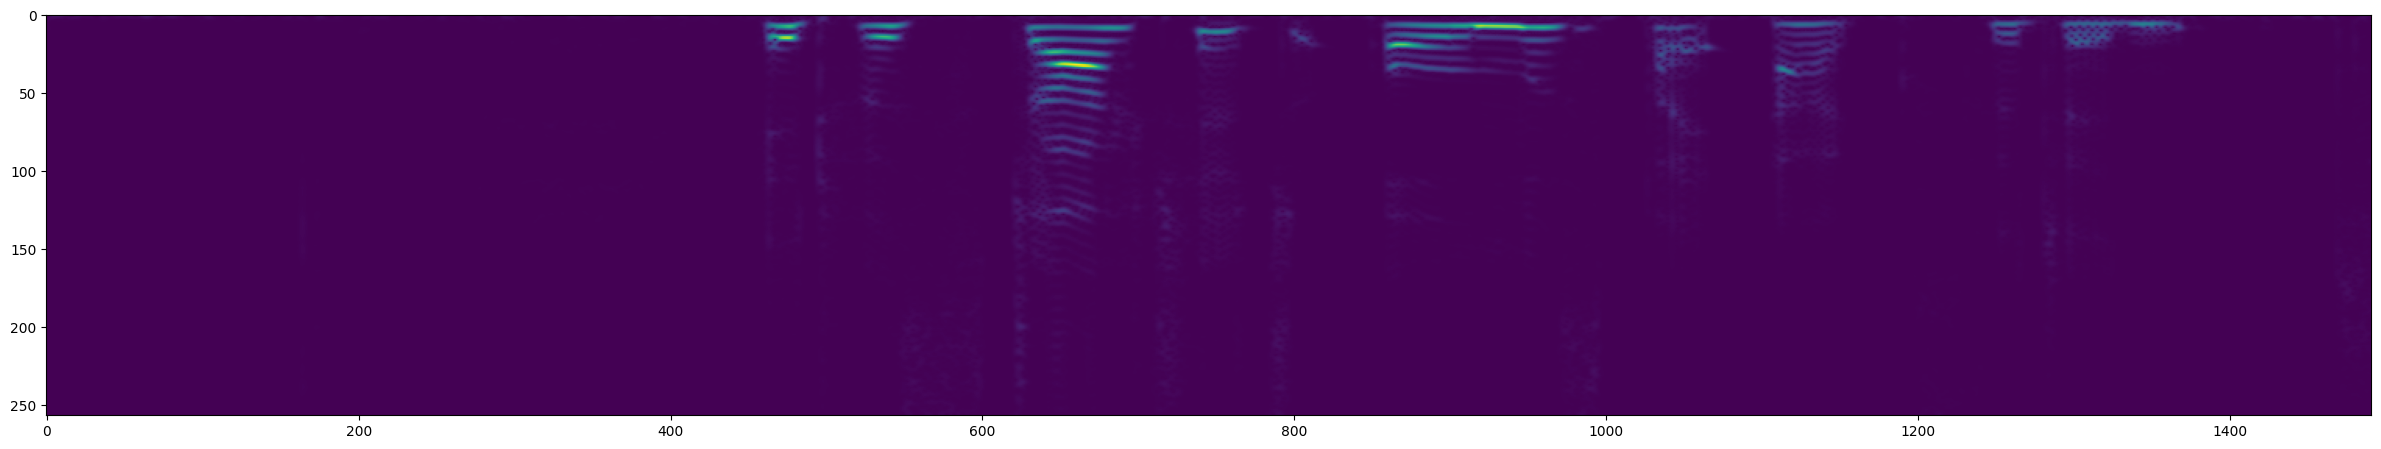

In [122]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [130]:
print(data)
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


TypeError: in user code:

    File "C:\Users\Edward\AppData\Local\Temp\ipykernel_2880\3027806908.py", line 2, in preprocess  *
        file_contents = tf.io.read_file(file_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [129]:
train = data.take(36)
test = data.skip(36).take(15)
print(train)
print(data)

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [127]:
samples, labels = train.as_numpy_iterator().next()

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Bad audio format for WAV: Expected 1 (PCM), but got3
	 [[{{node DecodeWav}}]] [Op:IteratorGetNext]